## Northern Ireland streamflow daily data pre-processing

#### Since the Camels-GB does not encompass data from Northern Ireland, the main objective of this script is to download the data from the official UK website and pre process it.

Written by: Thiago Victor Medeiros do Nascimento

References:

1. CAMELS-GB: https://catalogue.ceh.ac.uk/documents/8344e4f3-d2ea-44f5-8afa-86d2987543a9
2. Paper: https://essd.copernicus.org/articles/12/2459/2020/
3. Global Runoff Data Center: https://www.bafg.de/GRDC/EN/Home/homepage_node.html
4. NRFA: https://nrfa.ceh.ac.uk/data/search
5. NRFA API: https://nrfaapps.ceh.ac.uk/nrfa/nrfa-api.html#parameter-station

First we import some useful modules:

In [1]:
import geopandas as gpd                                      # Pandas for geospatial analysis
from shapely.geometry import Point, Polygon                  # Module used for geospatial analysis     
import pymannkendall as mk                                   # Module used for trend-computation
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings                                              
import datetime                                              # Datetime module pretty useful for time-series analysis
import tqdm as tqdm                                          # Useful module to access the progress bar of a loop
import os
import glob
warnings.simplefilter(action='ignore', category=Warning)     # Module useful for taking out some unecessary warnings


%config Completer.use_jedi = False                           # This improve the auto-fill function

import geospatialfunctions as geospatialfunctions            # Geospatialfunctions is a module with useful functions

First we should set our directory:

In [2]:
path = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Datasets"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Eawag\\Python\\Datasets'

1. Here we can import the full network information. Beforehand the network only for NI was organized using QGIS. 

In [4]:
network_NI_nrfa = pd.read_excel(r'NorthernIreland\network_NI_nrfa.xlsx', index_col = 0)
network_NI_nrfa

,name,catchment-,easting,northing,latitude,longitude,river,location,station-le,measuring-,...,mean-flood,mean-flo_1,mean-flo_2,urbext-199,urbconc-19,urbloc-199,urbext-200,urbconc-20,urbloc-200,data-summa
id,,,,,,,,,,,,,,,,,,,,,
201002,Fairywater at Dudgeon Bridge,158.40,240562,375809,54.62884,-7.37271,Fairywater,Dudgeon Bridge,61.0,DfIR,...,1.368,0.823,0.1246,0.0044,NaN,NaN,0.0006,NaN,NaN,gdf
201005,Camowen at Camowen Terrace,276.60,246071,373048,54.60357,-7.28785,Camowen,Camowen Terrace,66.0,DfIR,...,0.808,0.927,0.0798,0.0212,NaN,0.515,0.0034,NaN,NaN,gdf
201006,Drumragh at Campsie Bridge,320.00,245943,372192,54.59589,-7.28997,Drumragh,Campsie Bridge,63.0,DfIR,...,0.980,0.903,0.0991,0.0070,-1.688,0.411,0.0026,NaN,NaN,gdf
201007,Burn Dennet at Burndennet,148.30,237256,404779,54.88932,-7.42019,Burn Dennet,Burndennet,6.4,DfIR,...,0.515,0.752,0.0460,0.0044,NaN,NaN,0.0004,NaN,NaN,gdf
201008,Derg at Castlederg,335.40,226512,384216,54.70529,-7.58948,Derg,Castlederg,43.0,DfIR,...,0.907,0.887,0.0771,0.0021,NaN,NaN,0.0007,NaN,NaN,gdf
201009,Owenkillew at Crosh,440.10,241855,386684,54.72642,-7.35114,Owenkillew,Crosh,40.0,DfIR,...,0.510,0.963,0.0441,0.0016,NaN,NaN,0.0002,NaN,NaN,gdf
201010,Mourne at Drumnabuoy House,1843.80,234779,395968,54.81035,-7.45984,Mourne,Drumnabuoy House,7.0,DfIR,...,0.891,0.994,0.0787,0.0121,NaN,0.816,0.0030,NaN,NaN,gdf
202001,Roe at Ardnargle,364.40,267344,424637,55.06452,-6.94673,Roe,Ardnargle,5.4,DfIR,...,0.705,0.786,0.0595,0.0149,NaN,0.355,0.0064,0.842,0.415,gdf
202002,Faughan at Drumahoe,273.10,246411,415098,54.98123,-7.27587,Faughan,Drumahoe,7.0,DfIR,...,0.477,0.896,0.0411,0.0106,NaN,0.383,0.0044,0.300,0.117,gdf


2. Now we use the API to download the time-series data for each station:

#### API:

Now we can proceed with the download of the most uptodate time-series from the official website as described in (https://nrfaapps.ceh.ac.uk/nrfa/nrfa-api.html#parameter-station). For that, we use the API where it is only needed to create the URLs:

In [5]:
#Here we get the name of each used station:
gauges = network_NI_nrfa.index.tolist()

In [6]:
# Here we import some useful libraries:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [7]:
# Here we can proceed with the donwload of the dataset:
URL_original = "https://nrfaapps.ceh.ac.uk/nrfa/ws/time-series?format=nrfa-csv&data-type=gdf&station=CODE"

driver = webdriver.Chrome()
for gauge in tqdm.tqdm(gauges):
    URL_final = URL_original.replace("CODE", str(gauge))
    driver.get(URL_final)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:08<00:00,  6.82it/s]


#### Data organization:

Here we can proceed with the read and organization of our dataset:

In [13]:
# First we can check our files within the folder:
path =r'NorthernIreland\original'
filenames = glob.glob(path + "/*.csv")
len(filenames)

51

In [14]:
i = 0
timeseriesfinal_up = pd.DataFrame(index = pd.date_range('01-01-1970','12-31-2022', freq='D'))

#### The tqdm module is useful for checking the progress bar of the loop.
for filename in tqdm.tqdm(filenames):
    
    # The number of rows before the real streamflow data is variable, then we can solve it as:
    # First we select the row where we have the second column with the value "last", and we know that the stremflow starts
    # right after that:
    dataframefull = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = 0, delimiter = ",", header = None)
    rownnumber = dataframefull.index[dataframefull[1] == "last"].tolist()[0]
    
    # Now we read our time-series:
    data = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = rownnumber + 1, 
                       delimiter = ",", usecols = [0, 1], names = ["dates", "Qm3s"])

    # Convert our column of dates to datetime format:
    data["dates"] = pd.to_datetime(data["dates"], format='%Y-%m-%d')

    # Here we can set the index as the dates column:
    data.set_index("dates", inplace = True)

    # Here we can retrieve the station name:
    namestation = dataframefull.iloc[3, 2]
    
    timeseriesfinal_up.loc[:, int(namestation)] = data.Qm3s

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:03<00:00, 15.47it/s]


In [17]:
timeseries_NI = timeseriesfinal_up.copy()

Here we save our data:

In [21]:
#timeseries_NI.to_excel(r'GB\timeseries\timeseries_NI.xlsx')

In [27]:
network_NI = network_NI_nrfa.loc[timeseries_NI.columns]
#network_NI.to_excel(r'GB\timeseries\network_NI.xlsx')

Now we can analyse our data:

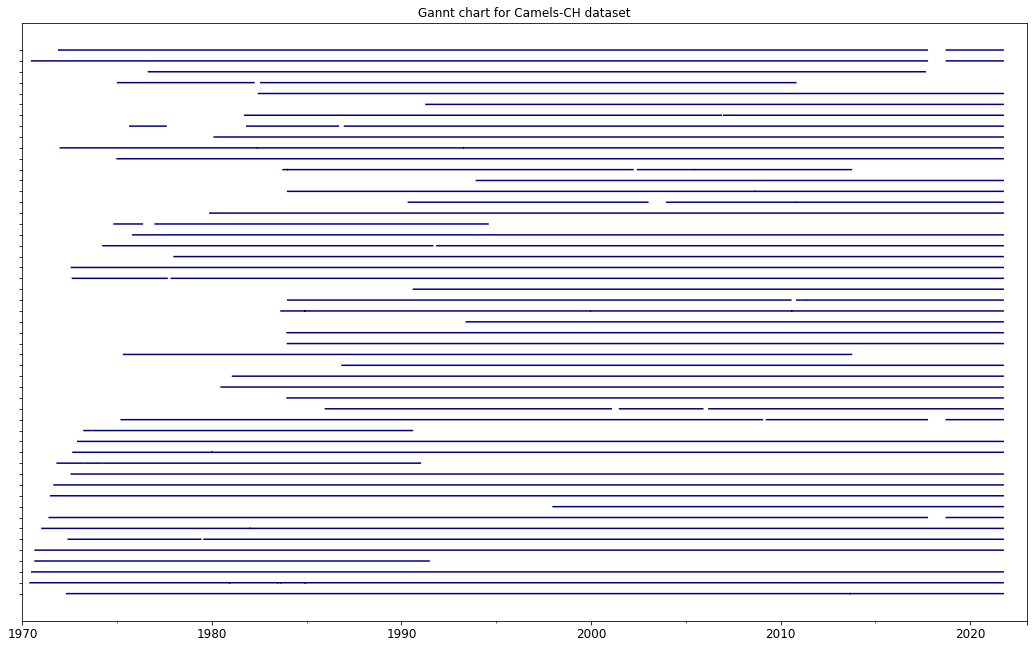

In [18]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseries_NI, 
                                                       
                                                       figsize_chart = (18, 11), showcodes = False,
                                                       color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                                       title_chart = "Gannt chart for Camels-CH dataset")

In [28]:
network_NI.head()

,name,catchment-,easting,northing,latitude,longitude,river,location,station-le,measuring-,...,mean-flood,mean-flo_1,mean-flo_2,urbext-199,urbconc-19,urbloc-199,urbext-200,urbconc-20,urbloc-200,data-summa
201005,Camowen at Camowen Terrace,276.6,246071,373048,54.60357,-7.28785,Camowen,Camowen Terrace,66.0,DfIR,...,0.808,0.927,0.0798,0.0212,NaN,0.515,0.0034,NaN,NaN,gdf
203011,Main at Dromona,243.5,304877,409012,54.91773,-6.36523,Main,Dromona,71.0,DfIR,...,1.192,0.846,0.1291,0.0062,NaN,1.102,0.0018,NaN,NaN,gdf
203012,Ballinderry at Ballinderry Bridge,430.2,292678,379835,54.65813,-6.56471,Ballinderry,Ballinderry Bridge,16.0,DfIR,...,0.787,0.889,0.0910,0.0227,NaN,0.779,0.0055,0.767,0.769,gdf
203017,Upper Bann at Dynes Bridge,316.3,304300,351100,54.39783,-6.39486,Upper Bann,Dynes Bridge,13.0,DfIR,...,0.692,0.929,0.0781,0.0238,NaN,0.480,0.0095,0.798,0.489,gdf
203018,Six-Mile Water at Antrim,277.6,314528,386672,54.71503,-6.22363,Six-Mile Water,Antrim,13.0,DfIR,...,0.870,0.881,0.0894,0.0304,NaN,0.744,0.0255,0.841,0.863,gdf


In [30]:
coords = network_NI[["longitude", "latitude"]]
coords.astype(float)

summarygapsstations = geospatialfunctions.summarygaps(timeseries_NI, coords)

summarygapsstations

,CoordX,CoordY,NumGaps,PercentageGaps
Code,,,,
201005,-7.28785,54.60357,1312.0,6.777560
203011,-6.36523,54.91773,653.0,3.373282
203012,-6.56471,54.65813,636.0,3.285463
203017,-6.39486,54.39783,11763.0,60.765575
203018,-6.22363,54.71503,701.0,3.621242
203019,-6.50079,54.87266,1400.0,7.232152
203020,-6.51548,54.75354,836.0,4.318628
203021,-6.28160,54.80962,1338.0,6.911871
203022,-7.03778,54.42201,10684.0,55.191652


(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

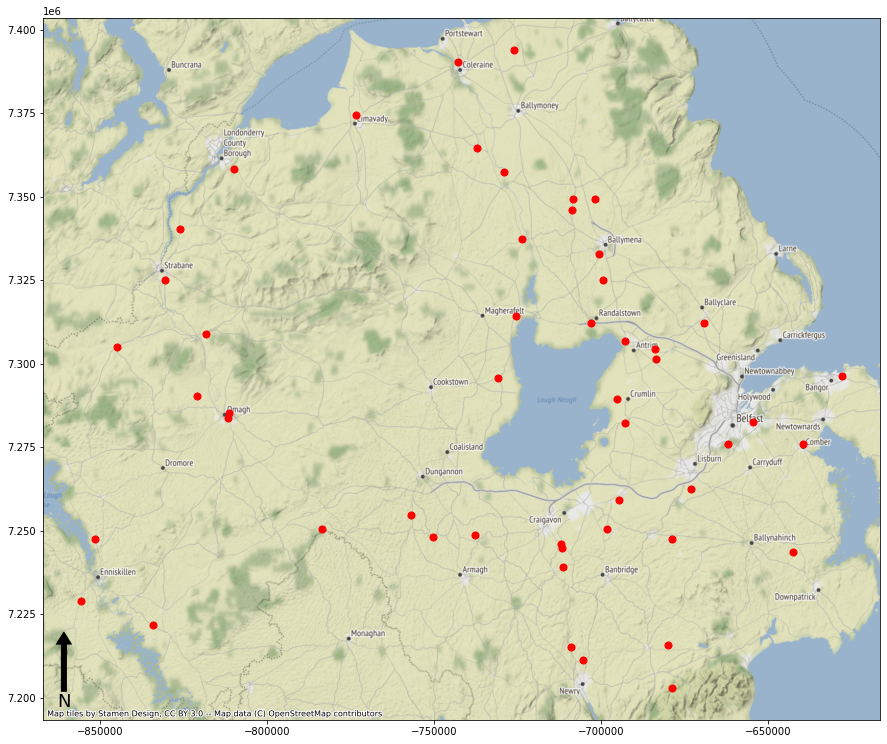

In [31]:
geospatialfunctions.plotpointsmap(coords, markersize_map = 50, colorpoints = 'red')

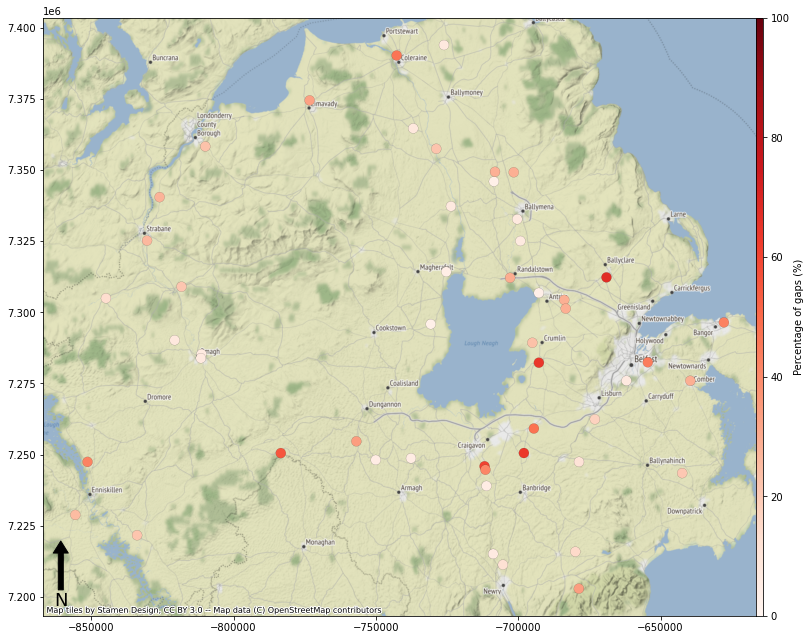

In [32]:
figplot, axesplot = geospatialfunctions.plotgapsmap(summarygapsstations = summarygapsstations, crsproj = 'epsg:4326', backmapproj = True, 
                                       figsizeproj = (18, 11), cmapproj = "Reds", legend_title = "Percentage of gaps (%)",
                                       legend_orientation = "vertical", pad_map = 0, markersize_map = 100,
                                       north_arrow = True, 
                                       set_map_limits = False, minx = -25, miny = 35, maxx = 30, maxy = 72)

In [35]:
summarygapsstations[summarygapsstations.PercentageGaps < 30.0]

,CoordX,CoordY,NumGaps,PercentageGaps,geometry
Code,,,,,
201005,-7.28785,54.60357,1312.0,6.777560,POINT (-7.28785 54.60357)
203011,-6.36523,54.91773,653.0,3.373282,POINT (-6.36523 54.91773)
203012,-6.56471,54.65813,636.0,3.285463,POINT (-6.56471 54.65813)
203018,-6.22363,54.71503,701.0,3.621242,POINT (-6.22363 54.71503)
203019,-6.50079,54.87266,1400.0,7.232152,POINT (-6.50079 54.87266)
203020,-6.51548,54.75354,836.0,4.318628,POINT (-6.51548 54.75354)
203021,-6.28160,54.80962,1338.0,6.911871,POINT (-6.28160 54.80962)
203024,-6.38868,54.36172,1000.0,5.165823,POINT (-6.38868 54.36172)
203025,-6.62695,54.41256,1065.0,5.501601,POINT (-6.62695 54.41256)
